## Generate plate/continent RMS velocity figures.

In [1]:
from __future__ import print_function

from astropy_healpix import healpy
import pygplates
from ptt.utils import points_in_polygons
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.signal import medfilt

import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True


#######################################################
# Define Input files
#######################################################

print(pygplates.__version__)

model_dir = 'Global_1000-0_Model_2017'

if model_dir == 'Global_1000-0_Model_2017':
    # Define the time snapshots.
    time_step = 5
    min_time = time_step
    max_time = 1000
    
    rotation_base_filenames = ['1000_0_rotfile_Merdith_et_al']

    # Models to plot.
    model_infos = [
        #(None, 'red', 'Not Optimized'),
        #('git_20200909_67baa20_run29', 'green', 'NR=1; TM=0.5; PV=0.5 (plate fragmentation)'),
        #('git_20200909_67baa20_run30', 'green', 'NR=1; TM=0.5; PV=0.5 (continent fragmentation)'),
        #('git_20200909_67baa20_run31', 'blue', 'NR=1; TM=0.5; PV=0.5 (without continent fragmentation)'),
        ('git_20210503_89d7a7e_run32', 'darkorange', 'NR=1; TM=0.5; PV=0'),
        ('git_20210503_89d7a7e_run33', 'green', 'NR=0; TM=0; PV=1 (without continent fragmentation)'),
        ('git_20210503_89d7a7e_run34', 'blue', 'NR=0; TM=0; PV=1 (with continent fragmentation)'),
    ]
    
else:
    raise RuntimeError('Unknown model.')
    
input_dir = '../data/{0}'.format(model_dir)
output_dir = './{0}'.format(model_dir)

original_rotation_filenames = [os.path.join(input_dir, rotation_base_filename + '.rot')
        for rotation_base_filename in rotation_base_filenames]

if model_dir == 'Global_1000-0_Model_2017':
    topology_base_filenames = [
        '250-0_plate_boundaries_Merdith_et_al.gpml',
        '410-250_plate_boundaries_Merdith_et_al.gpml',
        '1000-410-Convergence_Merdith_et_al.gpml',
        '1000-410-Divergence_Merdith_et_al.gpml',
        '1000-410-Topologies_Merdith_et_al.gpml',
        '1000-410-Transforms_Merdith_et_al.gpml',
        'TopologyBuildingBlocks_Merdith_et_al.gpml',
    ]
    topology_filenames = [os.path.join(input_dir, base_filename)
            for base_filename in topology_base_filenames]
    
    continent_base_filenames = [
        'shapes_continents_Merdith_et_al.gpml'
    ]
    continent_filenames = [os.path.join(input_dir, base_filename)
            for base_filename in continent_base_filenames]
    
else:
    raise RuntimeError('Unknown model.')

# Plate features.
plate_features = [pygplates.FeatureCollection(file) for file in topology_filenames]

# Continent features.
continent_features = [pygplates.FeatureCollection(file) for file in continent_filenames]

# A list of times to sample.
times = range(min_time, max_time+1, time_step)

2.2.0.31


In [2]:
def calculate_velocities(points, polygons, polygon_plate_ids, rotation_model, time):
            
    # Calculate velocity vectors at all sample points.
    velocity_vectors = []
    
    # Find the resolved plate polygon or reconstructed continental polygon (if any) containing each point.
    point_plate_ids = points_in_polygons.find_polygons(
            points,
            # The resolved plate polygon (or reconstructed continental polygon) geometries...
            polygons,
            # The plate ID of each resolved topology or reconstructed continent (this is what is returned by 'find_polygons')...
            polygon_plate_ids)

    # Dictionary of point lists indexed by plate ID (ie, each plate ID has a list of associated points).
    points_by_plate_id_dict = {}

    # Each point is contained by one polygon.
    for point_index, point_plate_id in enumerate(point_plate_ids):
        # If we're using topological plates, then if point is not in any resolved boundary then
        # it either fell in a tiny crack/gap or the topologies don't have global coverage.
        # If we're using continental polygons, then if point is not in any continental boundary then
        # it is on oceanic crust, and if it's in two polygons then they overlap (which can happen
        # when continental polygons are reconstructed) and we only see the first polygon encountered.
        # In all cases we ignore the point.
        if point_plate_id is not None:
            # Create dictionary entry (an empty list) if first time encountered plate ID.
            if point_plate_id not in points_by_plate_id_dict:
                points_by_plate_id_dict[point_plate_id] = []
            # Add point to dictionary entry.
            points_by_plate_id_dict[point_plate_id].append(points[point_index])

    # Calculate velocities for each plate ID (at all points associated with each plate ID).
    for plate_id in points_by_plate_id_dict.keys():
        # Get equivalent stage rotation from 'time' to 'time - 1'.
        equivalent_stage_rotation = rotation_model.get_rotation(time - 1, plate_id, time)

        points_with_plate_id = points_by_plate_id_dict[plate_id]
        velocity_vectors_with_plate_id = pygplates.calculate_velocities(
                points_with_plate_id,
                equivalent_stage_rotation,
                1.0, #interval
                # Units of cm/yr...
                velocity_units=pygplates.VelocityUnits.cms_per_yr)
        velocity_vectors.extend(velocity_vectors_with_plate_id)
    
    return velocity_vectors

In [3]:
# HEALPix is a Hierarchical Equal Area isoLatitude Pixelization of a sphere.
# At base level (nSide=1) it has 12 pixels (of resolution ~58.6 degrees).
# Each subsequent level divides each pixel into 4 pixels (halving the resolution).
nSide = 2**5  # Resolution ~1.83 degrees (2^5 * 58.6)
longitudes, latitudes = healpy.pix2ang(nSide, np.arange(12 * nSide**2), lonlat=True)
sample_points = pygplates.MultiPointOnSphere(zip(latitudes, longitudes))

In [4]:
velocity_models = []

for model_info in model_infos:
    model_name, _, _ = model_info

    if model_name is None:
        # Un-optimised rotation model.
        rotation_model = pygplates.RotationModel(original_rotation_filenames)
    else:
        # Optimised rotation model.
        optimised_rotation_filenames = [
                os.path.join(input_dir, 'optimisation', rotation_base_filename + '_{0}.rot'.format(model_name))
                    for rotation_base_filename in rotation_base_filenames]
        rotation_model = pygplates.RotationModel(optimised_rotation_filenames)

    rms_plate_velocities = []
    rms_continent_velocities = []
    
    # Reconstruct.
    for time in times:
        
        # Resolve the topological plate polygons for the current time.
        resolved_topologies = []
        pygplates.resolve_topologies(plate_features, rotation_model, resolved_topologies, time)

        # Get a list of resolved polygons and a list of their plate IDs.
        plate_polygons = []
        plate_polygon_plate_ids = []
        for resolved_topology in resolved_topologies:
            plate_polygons.append(resolved_topology.get_resolved_boundary())
            plate_polygon_plate_ids.append(resolved_topology.get_feature().get_reconstruction_plate_id())

        plate_velocity_vectors = calculate_velocities(
                sample_points, plate_polygons, plate_polygon_plate_ids, rotation_model, time)
        plate_velocity_magnitudes = [vec.get_magnitude() for vec in plate_velocity_vectors]

        rms_plate_velocities.append(np.sqrt(np.mean(np.array(plate_velocity_magnitudes)**2)))

        
        # Reconstruct the static continental polygons.
        reconstructed_feature_geometries = []
        pygplates.reconstruct(continent_features, rotation_model, reconstructed_feature_geometries, time)

        # Get a list of reconstructed continental polygons and a list of their plate IDs.
        continent_polygons = []
        continent_polygon_plate_ids = []
        for reconstructed_feature_geometry in reconstructed_feature_geometries:
            continent_polygons.append(reconstructed_feature_geometry.get_reconstructed_geometry())
            continent_polygon_plate_ids.append(reconstructed_feature_geometry.get_feature().get_reconstruction_plate_id())

        continent_velocity_vectors = calculate_velocities(
                sample_points, continent_polygons, continent_polygon_plate_ids, rotation_model, time)
        continent_velocity_magnitudes = [vec.get_magnitude() for vec in continent_velocity_vectors]

        rms_continent_velocities.append(np.sqrt(np.mean(np.array(continent_velocity_magnitudes)**2)))
        
    
    velocity_models.append((rms_plate_velocities, rms_continent_velocities))

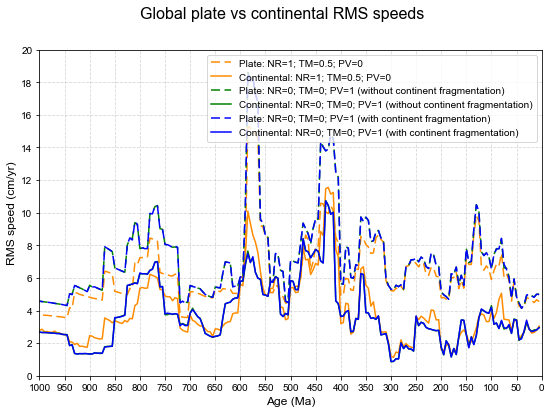

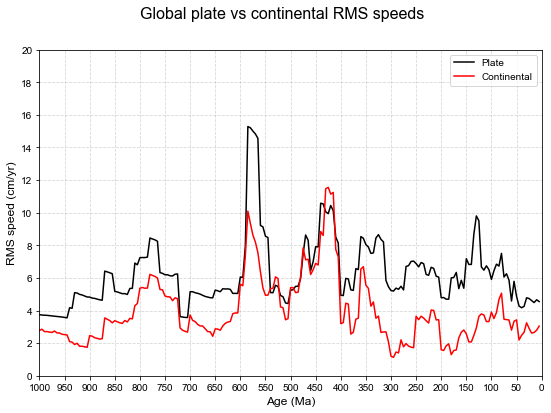

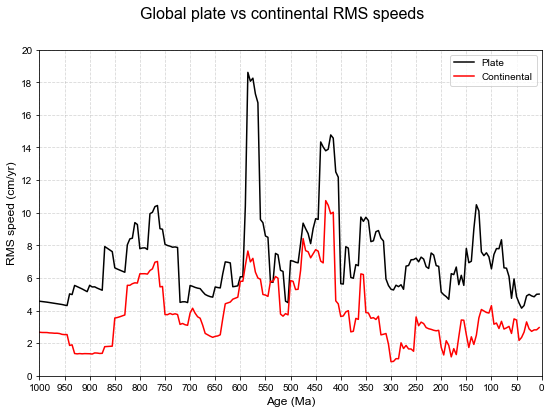

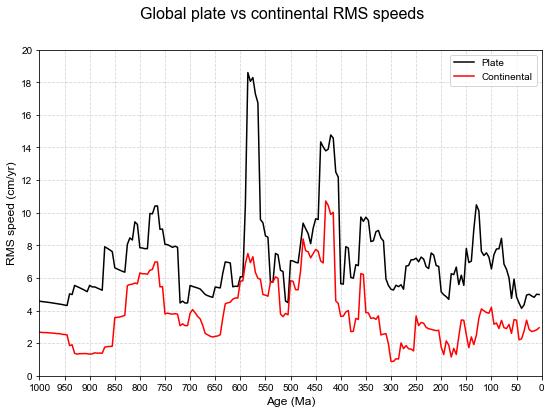

In [5]:
def plot_rms_velocities(medfilt_kernel_sizes):
    
    #
    # Plot figure(s) combining all models.
    #
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))
        
        fig.suptitle('Global plate vs continental RMS speeds', fontsize=16)

        for model_index in range(len(model_infos)):
            model_name, color, label = model_infos[model_index]
            
            rms_plate_velocities, rms_continent_velocities = velocity_models[model_index]
            
            # RMS plate velocities.
            plt.plot(
                times,
                medfilt(rms_plate_velocities, medfilt_kernel_size),
                color,
                dashes=(6,3), # Same colour but with dashes.
                label='Plate: {0}'.format(label))
            # RMS continent velocities.
            plt.plot(
                times,
                medfilt(rms_continent_velocities, medfilt_kernel_size),
                color,
                label='Continental: {0}'.format(label))

        plt.xlim([0, max_time])
        plt.ylim([0, 20])  # cms/yr
        plt.xticks(np.arange(0, max_time+1, 50))
        plt.yticks(np.arange(0, 20 + 1, 2))
        plt.ylabel('RMS speed (cm/yr)', fontsize=12)
        plt.xlabel('Age (Ma)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(model_dir, 'RMS_speeds_{0}My.pdf'.format(medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()
    
    
    #
    # Plot figure(s) with individual models.
    #
    for model_index in range(len(model_infos)):
        model_name, color, label = model_infos[model_index]
        
        rms_plate_velocities, rms_continent_velocities = velocity_models[model_index]
        
        fig = plt.figure(figsize=(9,6))
        fig.suptitle('Global plate vs continental RMS speeds', fontsize=16)
            
        # RMS plate velocities.
        plt.plot(
            times,
            medfilt(rms_plate_velocities, medfilt_kernel_size),
            'black',
            label='Plate')
        # RMS continent velocities.
        plt.plot(
            times,
            medfilt(rms_continent_velocities, medfilt_kernel_size),
            'red',
            label='Continental')

        plt.xlim([0, max_time])
        plt.ylim([0, 20])  # cms/yr
        plt.xticks(np.arange(0, max_time+1, 50))
        plt.yticks(np.arange(0, 20 + 1, 2))
        plt.ylabel('RMS speed (cm/yr)', fontsize=12)
        plt.xlabel('Age (Ma)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(
                    model_dir,
                    'RMS_speeds_{0}_{1}My.pdf'.format(
                            model_name if model_name else label,
                            medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()


#medfilt_kernel_sizes = [1, 5, 11]
medfilt_kernel_sizes = [1]

# Plot plate and continent RMS velocities for each model.
plot_rms_velocities(medfilt_kernel_sizes)

In [6]:
#
# Generate continental fragmentation index over time.
#
import sys
sys.path.insert(1, '../')
from continent_fragmentation import ContinentFragmentation

# Only need un-optimized rotation model since absolute plate motion shifts do not affect fragmentation.
# And so fragmentation index is the same for all optimised model runs.
original_rotation_filenames_rel_input_dir = [rotation_base_filename + '.rot'
        for rotation_base_filename in rotation_base_filenames]

# The grid spacing (in degrees) between points in the grid used for contouring/aggregrating blocks of continental polygons.
continental_fragmentation_point_spacing_degrees = 2.0

# Contour polygons smaller than this will be excluded when contouring/aggregrating blocks of continental polygons.
continental_fragmentation_area_threshold_steradians = 0.03

continent_fragmentation = ContinentFragmentation(
        input_dir,
        original_rotation_filenames_rel_input_dir,
        continent_features,
        False, # plate_velocity_features_are_topologies
        continental_fragmentation_point_spacing_degrees,
        continental_fragmentation_area_threshold_steradians,
        times)

fragmentation_indices = [
        continent_fragmentation.get_fragmentation(time, normalize=False) / 6371.0 # convert 1/radian to 1/km
        for time in times]

Calculating continental fragmentation for 5-1000Ma...


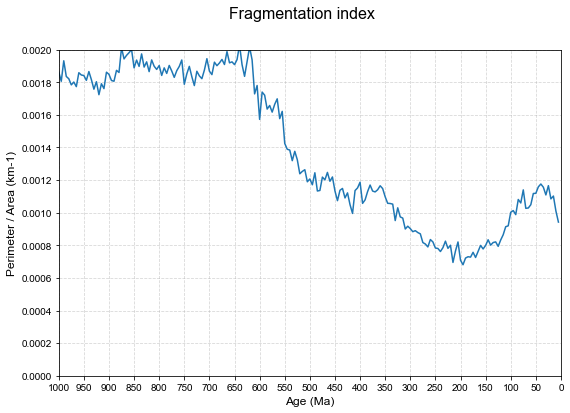

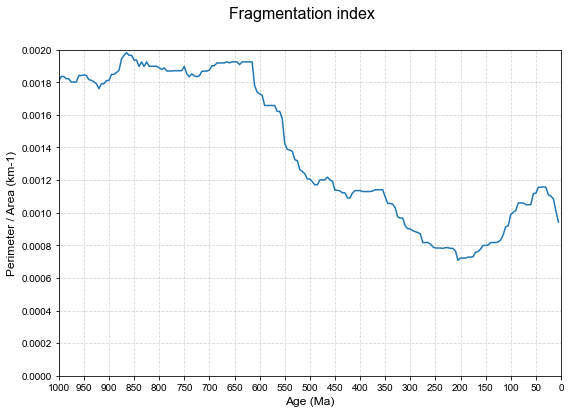

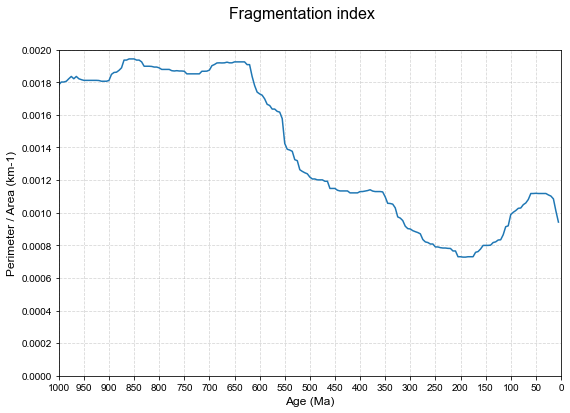

In [7]:
#
# Plot continental fragmentation index over time.
#

def plot_fragmentation_index(medfilt_kernel_sizes):
    
    #
    # Plot figure(s) combining all models.
    #
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))
        fig.suptitle('Fragmentation index', fontsize=16)

        plt.plot(
            times,
            medfilt(fragmentation_indices, medfilt_kernel_size))

        plt.xlim([0, max_time])
        plt.ylim([0, 0.002])
        plt.xticks(np.arange(0, max_time+1, 50))
        plt.yticks(np.arange(0, 0.0021, 0.0002))
        plt.ylabel('Perimeter / Area (km-1)', fontsize=12)
        plt.xlabel('Age (Ma)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        #plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(model_dir, 'continent_fragmentation_{0}My.pdf'.format(medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()

medfilt_kernel_sizes = [1, 5, 11]

# Plot plate and continent RMS velocities for each model.
plot_fragmentation_index(medfilt_kernel_sizes)        